In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight') 
plt.rcParams.update({'font.size': 40})
%matplotlib inline

import sys  
sys.path.insert(1, '../src/')

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error

# import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

In [2]:
mov_fast = pd.read_csv('../data/raw/Raw_traffic_and_movement_data/group2_order1_user1/group2_order1_user1_fast_movement.csv')
traffic_fast = pd.read_csv('../data/raw/Raw_traffic_and_movement_data/group2_order1_user1/group2_order1_user1_fast_traffic.csv')

In [3]:
print("Movement data shape: ", mov_fast.shape)
print("Traffic data shape: ", traffic_fast.shape)

Movement data shape:  (53011, 27)
Traffic data shape:  (2261391, 3)


In [4]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(traffic_fast.drop(columns = ["direction"])).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew,min,max,mean
time,float64,0,0.000000,2261391,2261391,-0.005711,0.000000,884.269390,443.346880
size,int64,0,0.000000,66,2261391,2.559626,27.000000,65535.000000,6951.933387


In [5]:
# SOURCE : https://github.com/signetlabdei/questset/blob/main/Traffic%20sample%20plots/generate_frame_traces.py
# set a threshold to filter out the smallest packets
size_th = 10 * 1e3  # [B]
theoretical_fps = 72  # [fps]
theoretical_ts = 1 / theoretical_fps  # [s]

In [6]:
# keep only relevant downlink data
dl_data = traffic_fast[traffic_fast["direction"] == "DL"]
dl_data = dl_data[dl_data["size"] > size_th]

Text(0.5, 1.0, 'Filtered Downlink Packets')

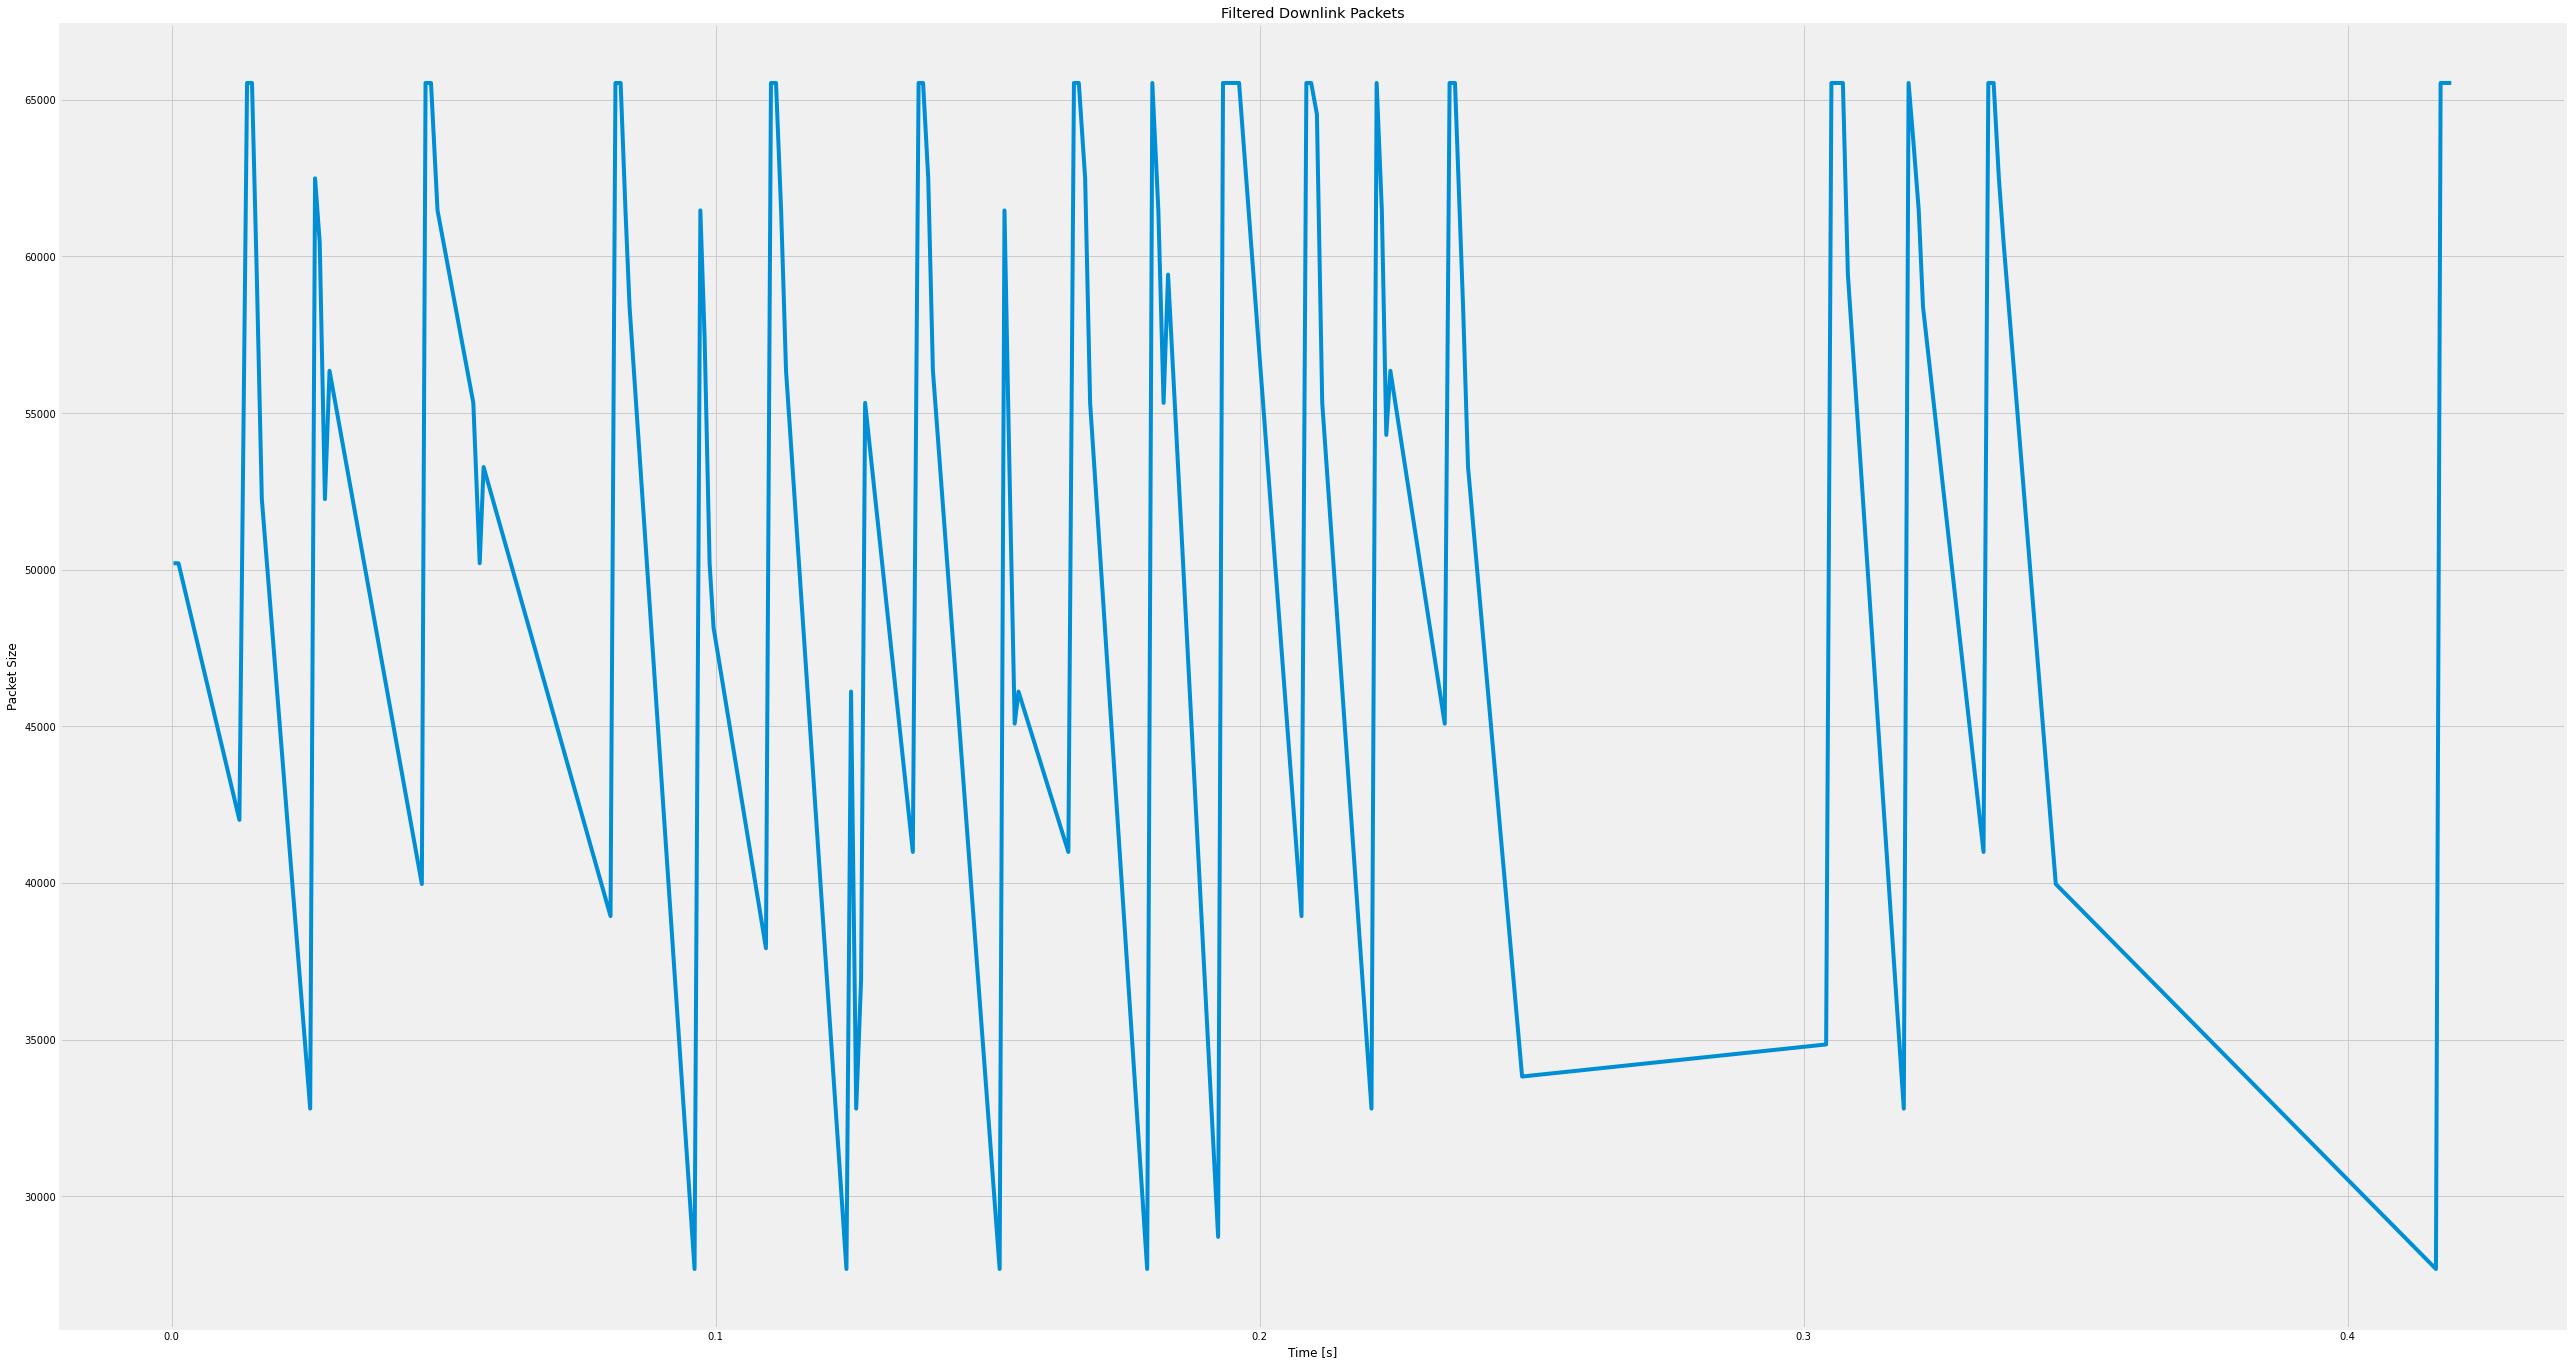

In [7]:
# Plot
plt.figure(figsize=(40, 24))
plt.plot(dl_data["time"][:100], dl_data["size"][:100], alpha=1)
plt.xlabel("Time [s]")
plt.ylabel("Packet Size")
plt.title("Filtered Downlink Packets")

In [8]:
# extract packet time and size
time_pkt = dl_data["time"].values
size_pkt = dl_data["size"].values
df = pd.DataFrame()

In [9]:
# compute the inter packet interval times
ipi = np.diff(time_pkt)

In [10]:
# group the packets that are closer than frame_t_thr_s into the same frame
frame_t_thr_s = 5e-3  # [s]
pkt_grp = ipi < frame_t_thr_s

frame_idx = 0
frame_size = []
frame_time = []
frame_pkts = []
tmp_size_b = size_pkt[0]
tmp_time_pkt = time_pkt[0]
pkt_counter = 0
frame_ids = [0]
frame_counter = 0
for ipi_idx, _ in enumerate(pkt_grp):
    if pkt_grp[ipi_idx]:
        if pkt_counter == 0:
            tmp_time_pkt = time_pkt[ipi_idx]
        pkt_counter += 1
        tmp_size_b += size_pkt[ipi_idx + 1]
    else:
        frame_pkts.append(pkt_counter)
        frame_size.append(tmp_size_b)
        frame_time.append(tmp_time_pkt)
        tmp_size_b = size_pkt[ipi_idx + 1]
        pkt_counter = 1
        tmp_time_pkt = time_pkt[ipi_idx + 1]
        frame_counter = frame_counter + 1
    frame_ids.append(frame_counter)

frame_size = np.array(frame_size)
frame_time = np.array(frame_time)
frame_ids = np.array(frame_ids)
frame_pkts = np.array(frame_pkts)

df["size"] = frame_size
df["time"] = frame_time
df["pkts"] = frame_pkts

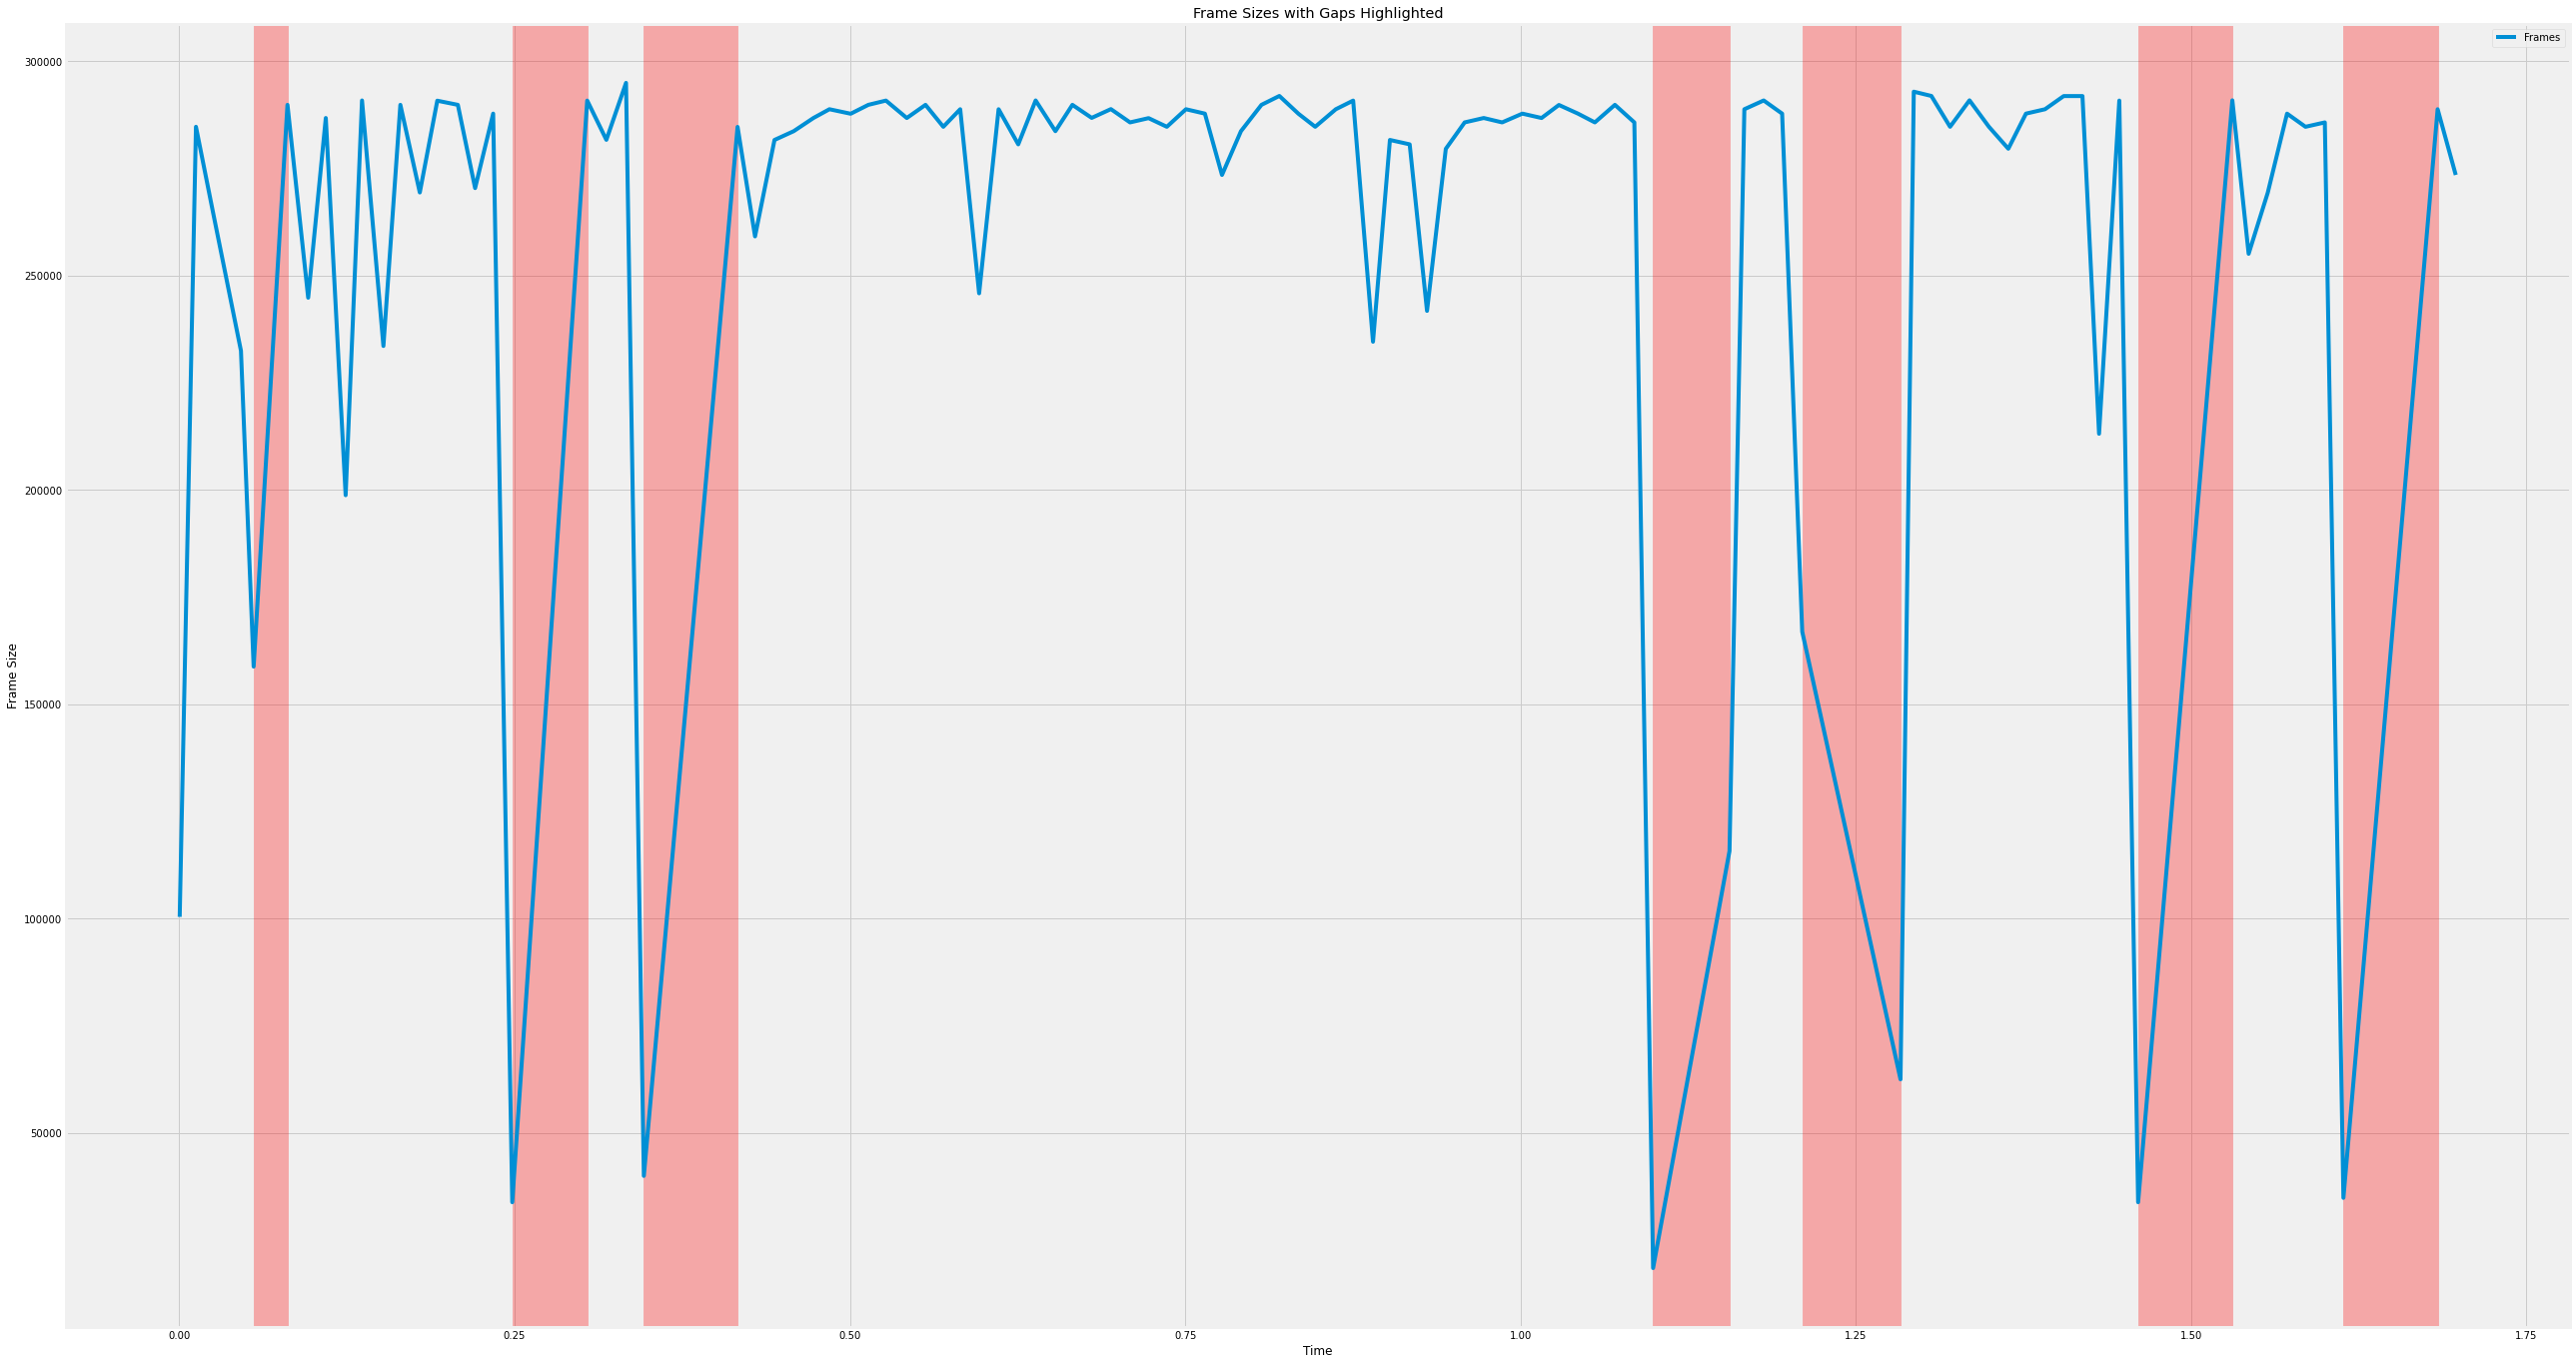

In [11]:
plt.figure(figsize=(40, 24))
plt.plot(frame_time[:100], frame_size[:100], label='Frames')
ifi = np.diff(frame_time[:100])
gap_threshold = 1.5 / theoretical_fps
gaps = ifi >= gap_threshold
for i in range(len(gaps)):
    if gaps[i]:
        plt.axvspan(frame_time[:100][i], frame_time[:100][i+1], color='red', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Frame Size')
plt.title('Frame Sizes with Gaps Highlighted')
plt.legend()

In [12]:
# if the time between frames is larger than the theoretical sampling time (1/FPS)
# fill the gaps with zero-size frames
ifi = np.diff(frame_time)
gaps_ids = ifi >= 1.5 / theoretical_fps

frame_time_fill = []
frame_size_fill = []
frame_pkts_fill = []
for frame_idx, _ in enumerate(gaps_ids):
    frame_time_fill.append(frame_time[frame_idx])
    frame_size_fill.append(frame_size[frame_idx])
    frame_pkts_fill.append(frame_pkts[frame_idx])
    if gaps_ids[frame_idx]:
        frame_time_0 = frame_time[frame_idx]
        frame_time_1 = frame_time[frame_idx + 1]
        gap_duration = frame_time_1 - frame_time_0
        n_frames_gap = gap_duration // theoretical_ts + 1

        for i in np.arange(1, int(n_frames_gap)):
            new_frame_time = frame_time_0 + i * theoretical_ts
            if new_frame_time >= frame_time_1 - theoretical_ts * 0.5:
                break
            frame_time_fill.append(new_frame_time)
            frame_size_fill.append(0)
            frame_pkts_fill.append(0)

frame_time_fill = np.array(frame_time_fill)
frame_size_fill = np.array(frame_size_fill)
frame_pkts_fill = np.array(frame_pkts_fill)

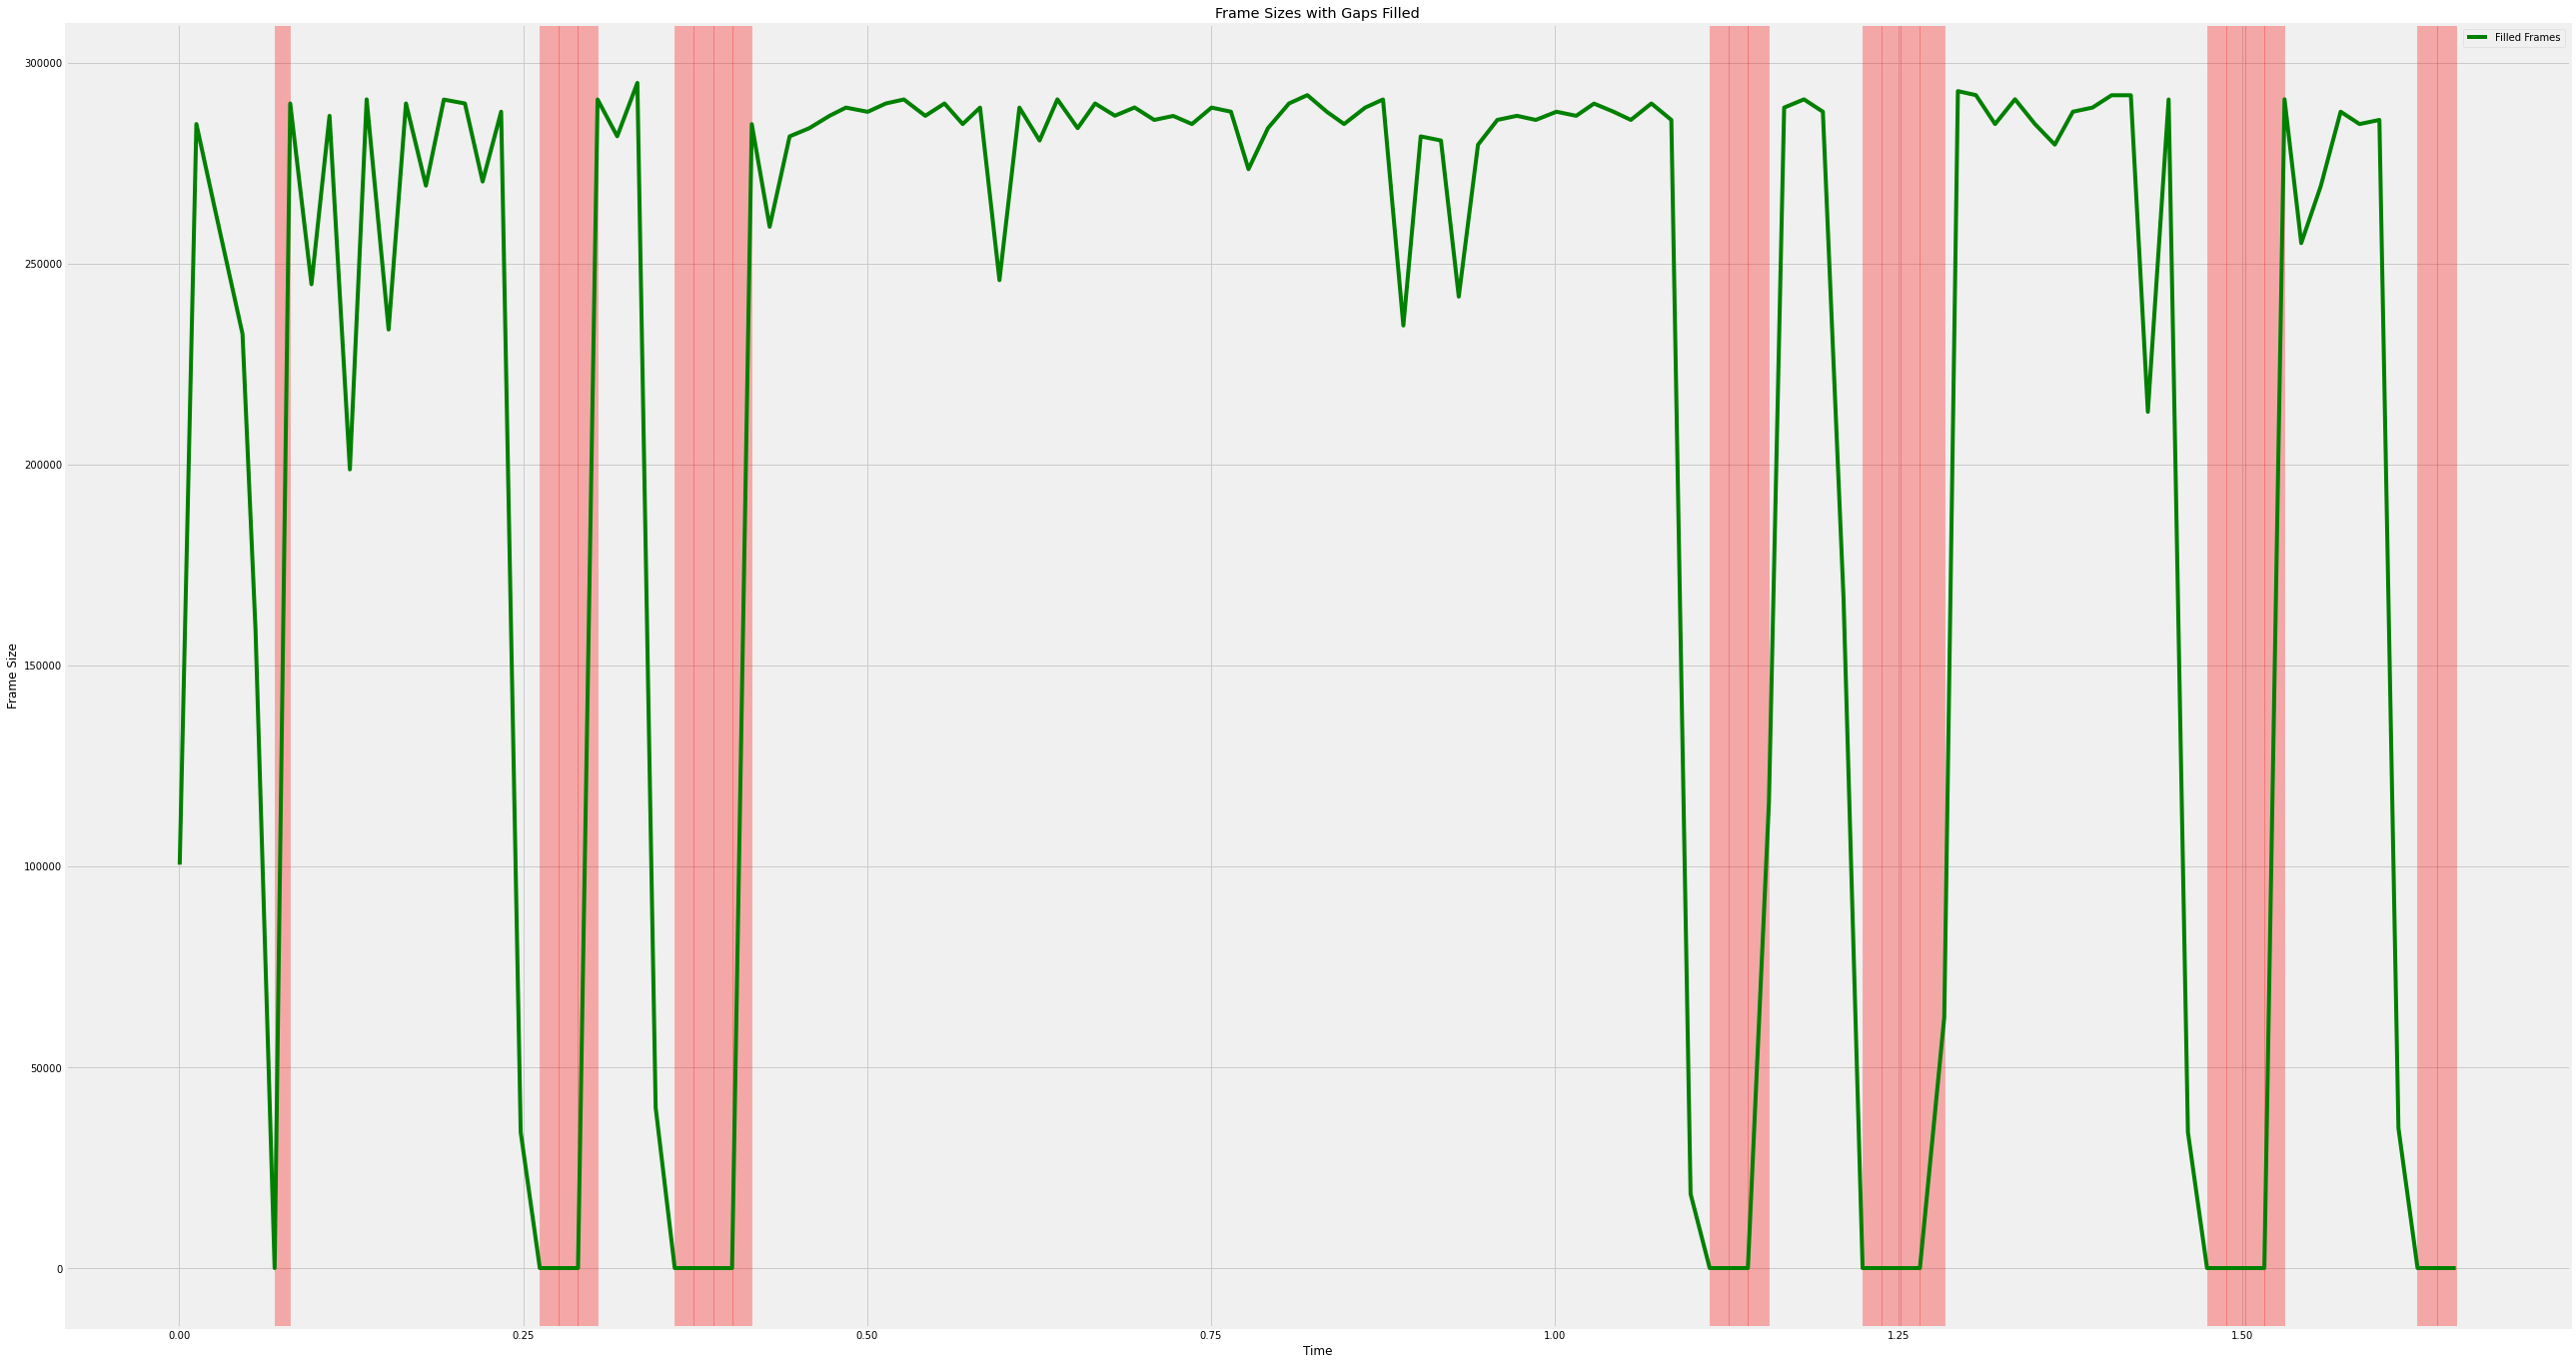

In [13]:
plt.figure(figsize=(40, 24))
plt.plot(frame_time_fill[:120], frame_size_fill[:120], c='green', label='Filled Frames')
#plt.plot(frame_time[:100], frame_size[:100], c='blue', label='Original Frames')
for i in range(len(frame_time_fill[:120]) - 1):
    if frame_size_fill[i] == 0:
        plt.axvspan(frame_time_fill[:120][i], frame_time_fill[:120][i+1], color='red', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Frame Size')
plt.title('Frame Sizes with Gaps Filled')
plt.legend()

In [14]:
filled_ifi = np.diff(frame_time_fill)
print(f"Theoretical IFI {theoretical_ts:.4f}")
print(
    f"Filled - Max IFI {max(np.diff(frame_time_fill)):.4f}, Min IFI {min(np.diff(frame_time_fill)):.4f}"
)
print(
    f"Not Filled - Max IFI {max(np.diff(frame_time)):.4f}, Min IFI {min(np.diff(frame_time)):.4f}"
)

frame_data = {"time": frame_time, "size": frame_size, "pkts": frame_pkts}
frame_data_df = pd.DataFrame(frame_data)

frame_data_fill = {
    "time": frame_time_fill,
    "size": frame_size_fill,
    "pkts": frame_pkts_fill,
}
frame_data_fill_df = pd.DataFrame(frame_data_fill)
frame_data_fill_df

Theoretical IFI 0.0139
Filled - Max IFI 0.0205, Min IFI 0.0059
Not Filled - Max IFI 0.3085, Min IFI 0.0059


,time,size,pkts
0,0.000294,100406,1
1,0.012418,284751,5
2,0.025430,264327,5
3,0.045960,232500,4
4,0.055421,158801,3
...,...,...,...
63514,884.181343,294023,5
63515,884.195356,293995,5
63516,884.209233,278663,5
63517,884.223154,246919,5


In [ ]:
gaps = np.diff(frame_time_fill) >= gap_threshold
gap_labels = np.zeros_like(frame_time_fill[:-1], dtype=int)
gap_labels[gaps] = 1

# Step 2: Create features
features = pd.DataFrame({
    'time': frame_time_fill[:-1],
    'size': frame_size_fill[:-1],
    'pkts': frame_pkts_fill[:-1],
    'ifi': np.diff(frame_time_fill)
})

In [78]:


# Convert data to sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 10

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['size', 'pkts', 'ifi']])

# Create sequences for training
X, y = create_sequences(scaled_features, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Model parameters
input_size = X.shape[2]
hidden_layer_size = 50
output_size = 3  # Predicting [size, pkts, ifi]

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_layer_size, output_size)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X)

    # Compute the loss
    loss = loss_function(y_pred, y)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item():.4f}')

print("Training complete.")

Epoch 0 Loss: 0.9973
Epoch 10 Loss: 0.9865
Epoch 20 Loss: 0.9776


KeyboardInterrupt: 

In [ ]:
# Extract LSTM features
model.eval()
with torch.no_grad():
    lstm_features = model(X).numpy()

# Calculate inter-frame intervals (IFI)
ifi = np.diff(frame_time)

# Define the gap threshold
gap_threshold = 1.5 / theoretical_fps

# Detect gaps
gaps = ifi >= gap_threshold

# Ensure gaps array length matches the LSTM output length
aligned_gaps = gaps[:len(lstm_features) - 1]

# Create binary target for gap presence
gap_presence = np.zeros(len(lstm_features) - 1)
gap_presence[aligned_gaps] = 1

# Calculate gap lengths for the gaps detected
gap_lengths = ifi[:len(aligned_gaps)][aligned_gaps]

# Split data for ML training
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(lstm_features[:-1], gap_presence, test_size=0.2, random_state=42)

# Train a classifier to predict gap presence
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_ml, y_train_ml)

# Predict gap presence on the test set
y_pred_ml = classifier.predict(X_test_ml)

# Evaluate the classifier
accuracy = accuracy_score(y_test_ml, y_pred_ml)
print(f'Gap Presence Prediction Accuracy: {accuracy:.2f}')

Gap Presence Prediction Accuracy: 0.94


In [ ]:
# Filter to only the data where gaps were predicted
predicted_gap_indices = np.where(y_pred_ml == 1)[0]

# Train a regressor to predict the length of the gap
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    lstm_features[:-1][aligned_gaps], gap_lengths, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Predict gap lengths on the predicted gaps from the test set
y_pred_gap_lengths_ml = regressor.predict(X_test_ml[predicted_gap_indices])

# Output the results
print(f'Predicted Gaps: {len(y_pred_gap_lengths_ml)}')

Predicted Gaps: 10


In [79]:
X_test_ml

array([[-0.08645942,  0.03757272,  0.13006544],
       [ 0.06956156,  0.06064171,  0.01029196],
       [-0.36903074, -0.09725424,  0.00981851],
       ...,
       [-0.8099833 , -1.0806996 , -0.2949061 ],
       [ 0.24752218,  0.12202797,  0.07973407],
       [ 0.11166726,  0.05886052, -0.26110545]], dtype=float32)

Predicted Gaps: 10


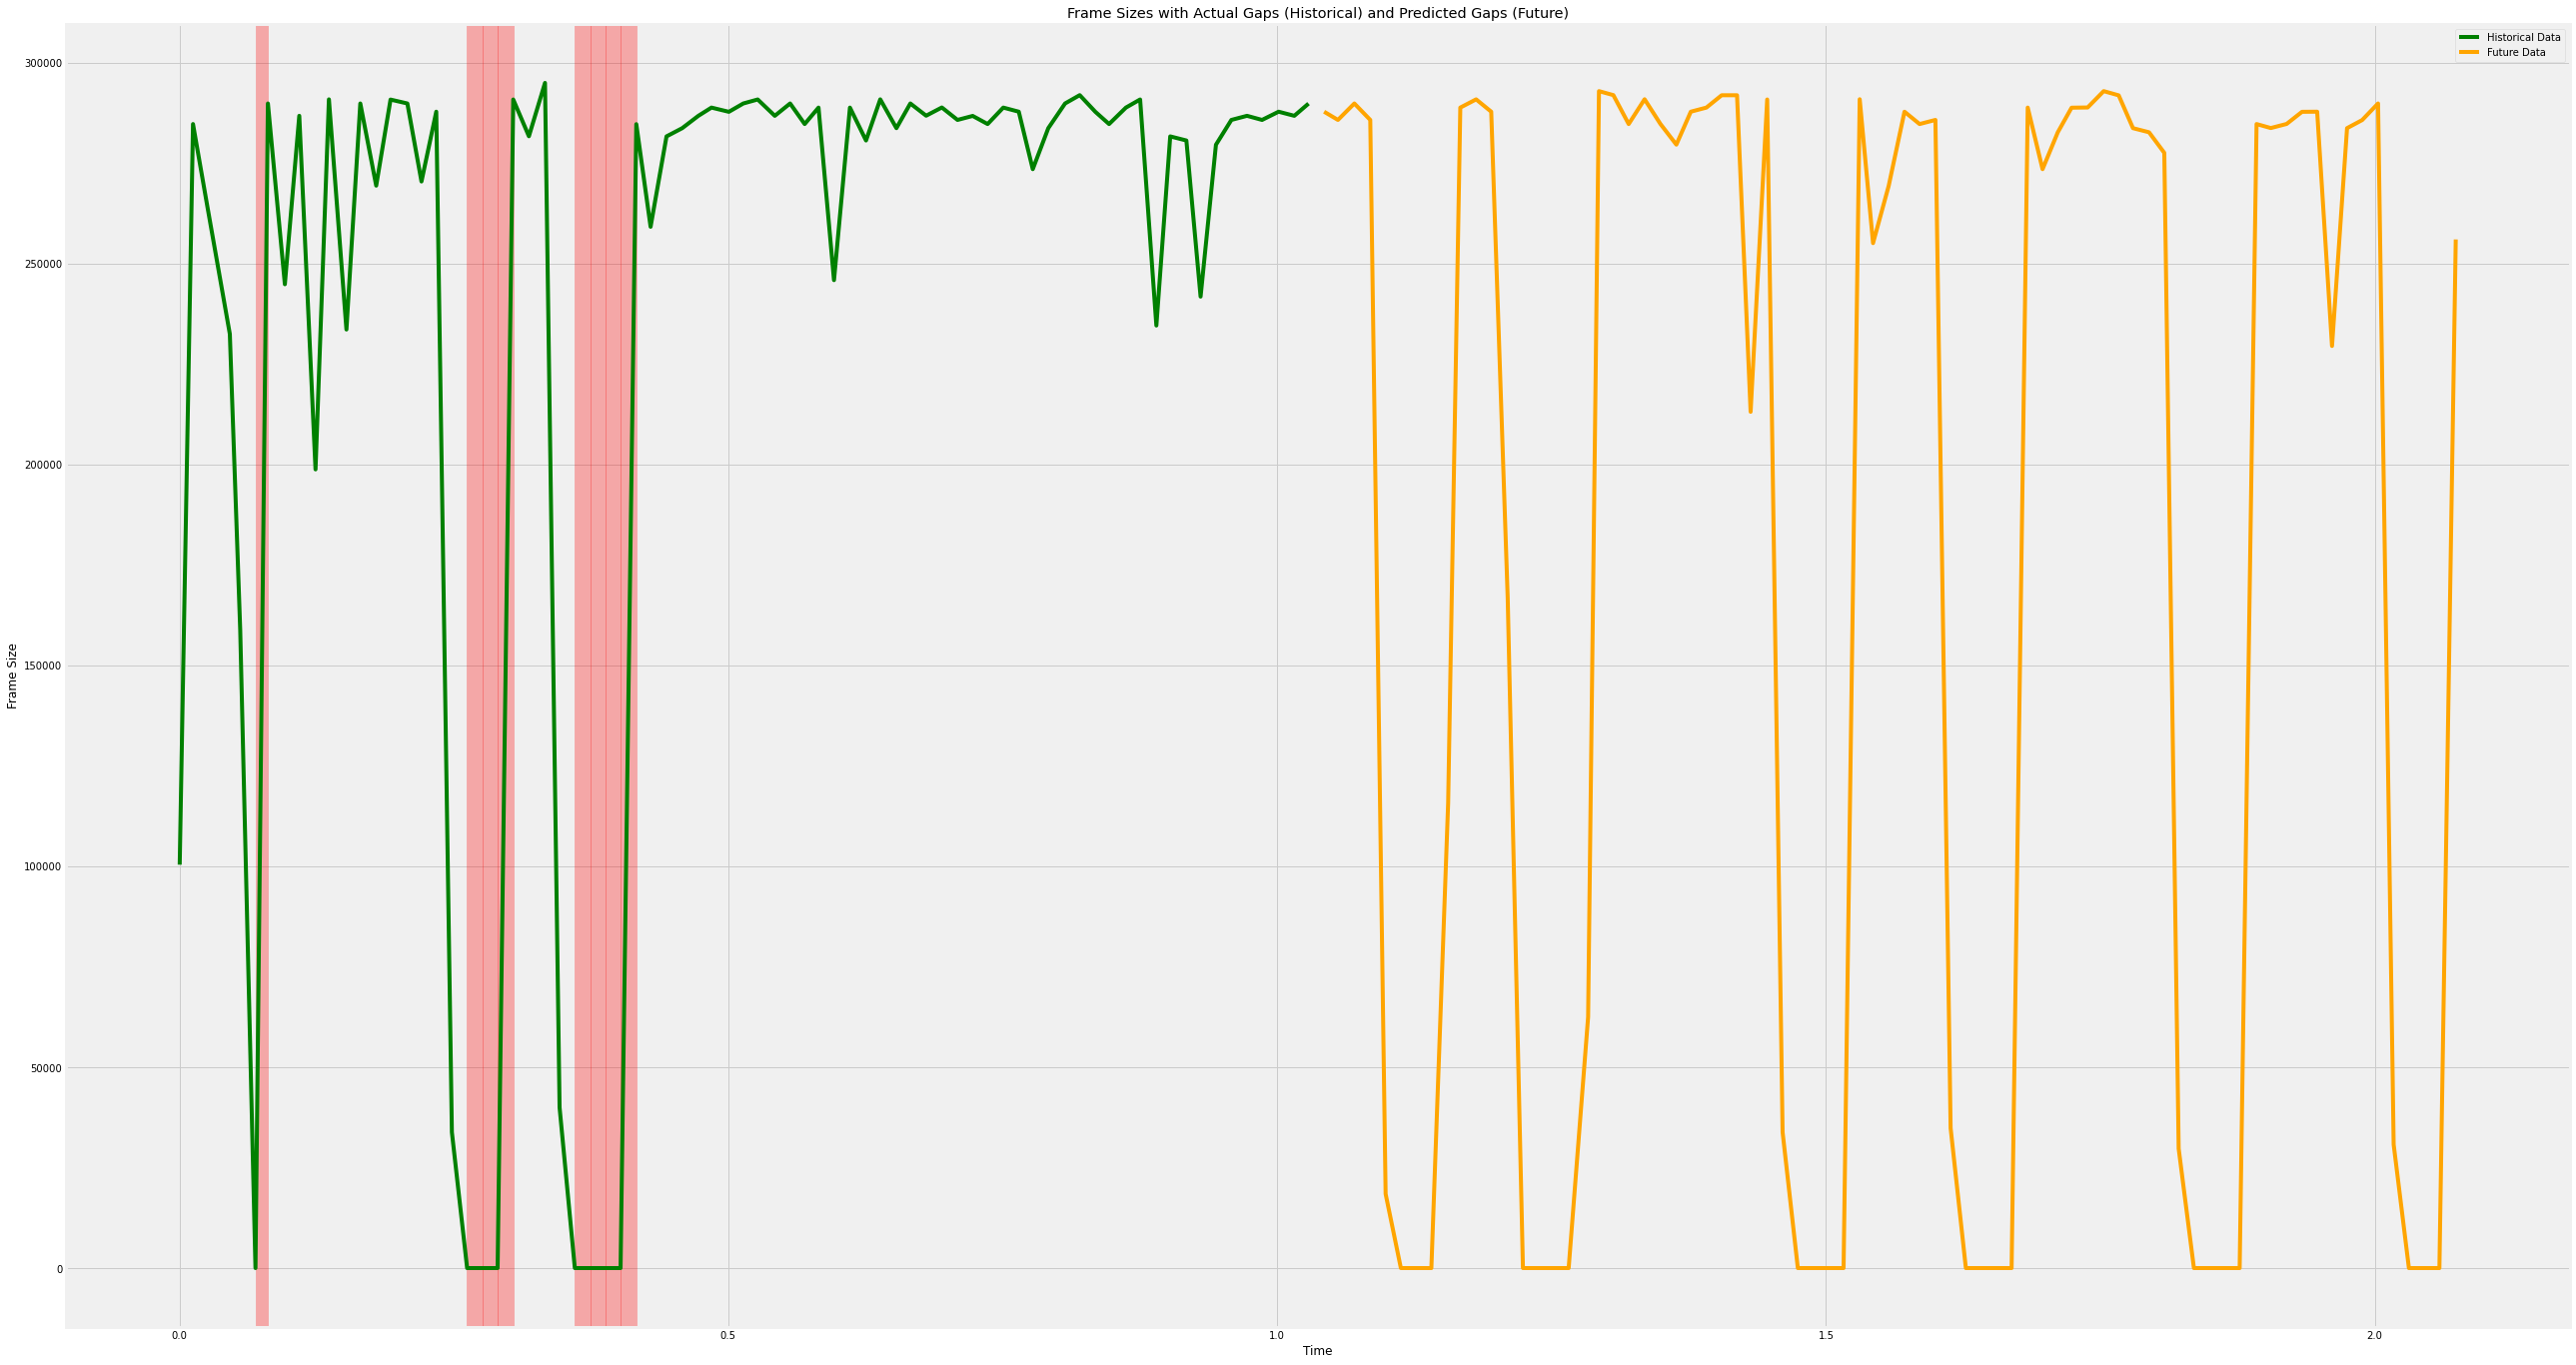

In [ ]:
# Plot the results
num_samples = 150
plt.figure(figsize=(40, 24))

# Plot the original frame sizes (limited to 150 samples)
plt.plot(frame_time_fill[:75], frame_size_fill[:75], c='green', label='Historical Data')
plt.plot(frame_time_fill[75:num_samples], frame_size_fill[75:num_samples], c='orange', label='Future Data')

# Highlight actual gaps in historical data
for i in range(75):
    if frame_size_fill[i] == 0:
        plt.axvspan(frame_time_fill[i], frame_time_fill[i + 1], color='red', alpha=0.3, label='Actual Gap' if i == 0 else "")

# Highlight predicted gaps in future data using ML model
for i, idx in enumerate(predicted_gap_indices):
    start_time = idx + 75
    end_time = start_time + int(y_pred_gap_lengths_ml[i])
    if end_time < num_samples:
        plt.axvspan(frame_time_fill[start_time], frame_time_fill[end_time], color='blue', alpha=0.3, label='Predicted Gap' if i == 0 else "")

plt.xlabel('Time')
plt.ylabel('Frame Size')
plt.title('Frame Sizes with Actual Gaps (Historical) and Predicted Gaps (Future)')
plt.legend()
plt.show()
